In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

### Load data

In [2]:
def get_df():
    df = []
    for fname in glob.glob("csse_covid_19_data/csse_covid_19_daily_reports/*.csv"):
        report_date = fname.split("/")[-1].replace(".csv", "")
        _df = pd.read_csv(fname)
        _df["report_date"] = report_date
        df.append(_df)
    df = pd.concat(df)
    df["Last Update"] = pd.to_datetime(df["Last Update"])
    df["report_date"] = pd.to_datetime(df["report_date"])
    df["date"] = df["report_date"] # seems to make more sense than the "Last Update"
    df = df.sort_values(by="date")
    df = df.drop_duplicates()
    return df

In [3]:
df = get_df()
df = df[df["Country/Region"] == "Germany"]
#df = df[df["Country/Region"].apply(lambda x : "Korea" in x)]
#df = df[df["Country/Region"].apply(lambda x : "China" in x)]
#df = df[df["Country/Region"] == "Italy"]
#df = df[df["Country/Region"] == "Japan"]
#df = df[df["Country/Region"] == "Belgium"]
#df = df[df["Country/Region"] == "Iran"]
#df = df[df["Country/Region"] == "Spain"]
#df = df[df["Country/Region"] == "France"]

# uncomment if using multiple regions/countries
df = df.groupby("date").sum()
df = df.reset_index()

#df = df.iloc[:-2]

In [4]:
df.tail()

,date,Confirmed,Deaths,Recovered,Latitude,Longitude
48,2020-03-16,7272.0,17.0,67.0,51.1657,10.4515
49,2020-03-17,9257.0,24.0,67.0,51.1657,10.4515
50,2020-03-18,12327.0,28.0,105.0,51.1657,10.4515
51,2020-03-19,15320.0,44.0,113.0,51.1657,10.4515
52,2020-03-20,19848.0,67.0,180.0,51.1657,10.4515


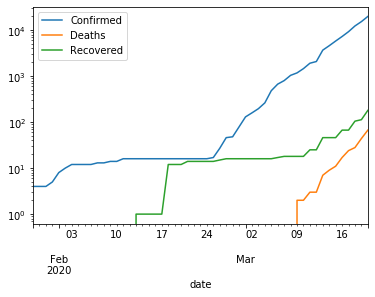

In [5]:
fig, ax = plt.subplots()
df.plot(x="date", y="Confirmed", ax=ax)
df.plot(x="date", y="Deaths", ax=ax)
df.plot(x="date", y="Recovered", ax=ax)
ax.set_yscale("log")

### Fit exponential

In [6]:
def func(x, a, b, c):
    return a * np.exp(b * (x - c))

In [7]:
# DataFrame contains cumulative cases (called 'int' here)
# np.diff gives new confirmed cases per day
#field = "Deaths"
field = "Confirmed"
x_int = df["date"].astype("int").values
x_int = (x_int - x_int[0]) / 1e9 / 3600 / 24
x = x_int[1:]
y = np.diff(df[field]) / np.diff(x_int)
y = np.nan_to_num(y)
y_int = df[field].values
y_int = np.nan_to_num(y_int)

Exponential fit for new confirmed cases per day:

In [8]:
popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=(1, len(x) / (x[-1] - x[0]), x[0]))

(array([737456., 737463., 737470., 737477., 737485., 737492., 737499.,
        737506.]),
 <a list of 8 Text xticklabel objects>)

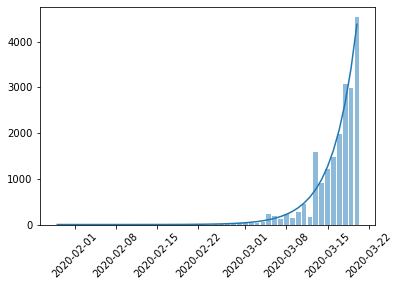

In [9]:
plt.bar(df["date"][1:], y, alpha=0.5)
plt.plot(df["date"][1:], func(x, *popt))
plt.xticks(rotation=45)

Exponential fit for cumulative cases:

In [10]:
popt_int, pcov_int = scipy.optimize.curve_fit(func, x_int, y_int, p0=(1, len(x) / (x[-1] - x[0]), x[0]))

Plot both new and cumulative

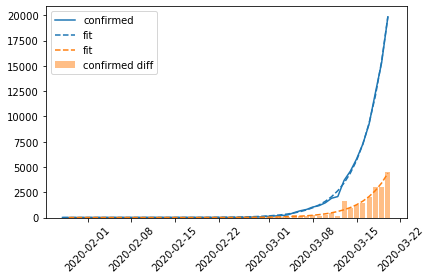

In [11]:
fig, ax = plt.subplots()

ax.plot(df["date"], y_int, label="confirmed", color="C0")
ax.plot(df["date"], func(x_int, *popt_int), "--", label="fit", color="C0")

ax.bar(df["date"][1:], y, label="confirmed diff", color="C1", alpha=0.5)
ax.plot(df["date"][1:], func(x, *popt), "--", label="fit", color="C1")

ax.xaxis.set_tick_params(rotation=45)
ax.legend()

ax.set_yscale("log")
ax.set_ylim(bottom=1e-1)
fig.tight_layout()
fig.savefig("corona_de_log.pdf")
ax.set_ylim(auto=True)
ax.set_yscale("linear")
fig.savefig("corona_de.pdf")

(0, 1)

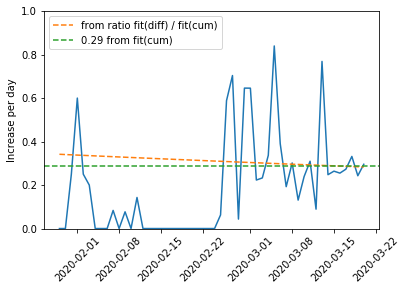

In [12]:
inc_from_param = np.exp(popt_int[1]) - 1
plt.plot(df["date"][1:], y / y_int[:-1])
plt.plot(
    df["date"][1:],
    func(x, *popt) / func(x_int, *popt_int)[:-1],
    color="C1",
    linestyle="--",
    label="from ratio fit(diff) / fit(cum)"
)
plt.axhline(inc_from_param, linestyle="--", color="C2", label=f"{inc_from_param:.2f} from fit(cum)")
plt.ylabel("Increase per day")
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0, 1)

### Extrapolation of cumulative cases

246771.3663588631

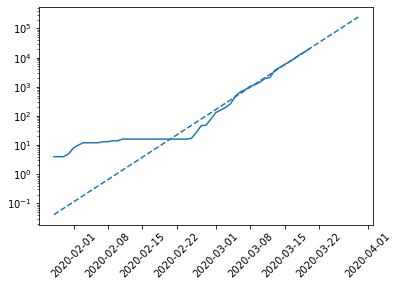

In [13]:
dates_extrap = pd.date_range(start=df.date.iloc[0], end="2020-03-30", freq="d")
days = np.arange(len(dates_extrap))
pred = func(days, *popt_int)
fig, ax = plt.subplots()
ax.plot(df["date"], y_int, label="confirmed", color="C0")
ax.plot(dates_extrap, pred, "--", color="C0")
ax.set_yscale("log")
ax.xaxis.set_tick_params(rotation=45)
pred[-1] # predicted by end of range

### Fitted Parameters and doubling time

In [14]:
popt

array([0.01222835, 0.24811134, 0.45613492])

In [15]:
popt_int

array([0.07162791, 0.25178961, 2.21799363])

In [16]:
np.log(2) / popt_int[1]

2.752882384297288

### Death rate

In [17]:
df["death_rate"] = df["Deaths"] / df["Confirmed"]

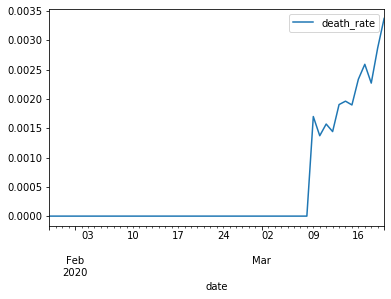

In [18]:
df.plot(x="date", y="death_rate")